# __Project P: PINPOINT PERFECT PARISH (Porto)__ 
## _by Ivan Kisialiou_  
## Capstone Project 
### _Coursera IBM Data Science Professional Certificate_  

The objective of my Capstone Project, named PINPOINT PERFECT PARISH (Porto),  
is to build a system that helps a customer to choose the district in Porto City to settle down.   

__Disclamer:__ I use back-ups in order to make system more robust to fluctuations of API request results

## Import libraries 

In [1]:
import pandas as pd                     # Dataframes
import numpy as np                      # Arrays
import re                               # Regular expressions
import string                           # String operations
import matplotlib.pyplot as plt         # Visualization

import matplotlib.cm as cm              # Colour scheme for the clusters
import matplotlib.colors as colors

'''Libraries for working with geo-data'''
#!pip install geopy
import geopy.distance                    # Distances between geo-points
from geopy.geocoders import Nominatim    # Geocoding
import folium                            # Interactive maps
#!pip install nvector
import nvector as nv                     # Calculating cross-track distance

'''Libraries for html parsing''' 
#!pip install beautifulsoup4
#!pip install lxml
#!pip show beautifulsoup4
from bs4 import BeautifulSoup
import requests
import lxml

'''API'''
from map_api import foursquare
'''
For security, API credentials are described
in a separate module map_api.py as follows:

class foursquare(object):
    """Foursquare api: key, secret, version"""
    def __init__(self):
        """Constructor"""
        self.id = "your_id"
        self.secret = "your_secret"
        self.version = "20190405"
'''

'''Scikit-learn Clustering'''
from sklearn.cluster import KMeans     # K-means clustering


'''Options'''
#pd.set_option('display.precision',6)

print('All necessary libraries are loaded')

All necessary libraries are loaded


# 1. DATA SCRAPING

## 1.2. Parsing
__Administrative division of Portugal__    
It includes Municipalities and Perishes ('Freguesias').  
One can see the full list [here](https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Portugal)  
  
__Let's parse the page and get the list of all Parishes together with their parent Municipalities__  

In [2]:
wikipedia_link = 'https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Portugal'

# Getting webpage to 'requests' object
raw_page = requests.get(wikipedia_link)

# Initialization of 'BeautifulSoup' object with parser 'lxml'
# and passing the text from 'requests' object as input
soup = BeautifulSoup(raw_page.text,'lxml')

# Get the main block of the page
portugal = soup.find('div',{'class':'mw-parser-output'})
portugal = portugal.find_all('div')[0:4]

# list of all Municipalities
municipalities = []
# list of Parish groups within each Municipality
parish_groups = []

for column in portugal:
    municipalities[len(municipalities):1] = column.find_all('h3')
    parish_groups[len(parish_groups):1] = column.find_all('ul')

print('Lists of data includes {} Municipalities and {} parish groups'
      .format(len(municipalities), len(parish_groups)))

# list of Municipalities for every Parish
muni = []
# list of all Parishes
pari = []

for municipality, parish in zip(municipalities,parish_groups):
    m_name = municipality.find('span',{'class':'mw-headline'}).text
    parish_list = parish.find_all('a')
    
    for p_name in parish_list:
        muni.append(m_name)
        pari.append(p_name.text)

print('Final list of data includes {} Parishes and {} parent Municipality entries'
      .format(len(pari),len(muni)))

Lists of data includes 308 Municipalities and 308 parish groups
Final list of data includes 3093 Parishes and 3093 parent Municipality entries


__Now we can create a Dataframe__  

In [3]:
df = pd.DataFrame(pari,muni).reset_index()
df.columns = ['Municipality','Parish']
df.sample(2)

,Municipality,Parish
2471,Sernancelhe,Vila da Ponte
1222,Idanha-a-Nova,Zebreira e Segura


## 1.3. Cleaning
__Let's filter 18 Municipalities of Porto District__  

In [4]:
porto_district_municipalities = {'Amarante','Baião','Felgueiras','Gondomar','Lousada','Maia',
                 'Marco de Canaveses','Matosinhos','Paços de Ferreira','Paredes','Penafiel','Porto',
                 'Póvoa de Varzim', 'Santo Tirso','Trofa','Valongo','Vila do Conde','Vila Nova de Gaia'}

__We can omit Municipalities that are too far from Porto City__  

In [5]:
far_municipalities = {'Amarante','Baião','Felgueiras','Lousada',
                      'Marco de Canaveses','Paços de Ferreira','Penafiel',
                     'Póvoa de Varzim'}
porto_aglomeration = porto_district_municipalities - far_municipalities
porto_city_df = df[df['Municipality'].isin(porto_aglomeration)].reset_index(drop=True)

print('From now we consider {} Parishes in Porto Agglomeration'
      .format(len(porto_city_df)))
porto_city_df.head(3)

From now we consider 105 Parishes in Porto Agglomeration


,Municipality,Parish
0,Gondomar,Baguim do Monte (Rio Tinto)
1,Gondomar,Fânzeres e São Pedro da Cova
2,Gondomar,Foz do Sousa e Covelo


__Some Parishes are joint (e.g. “Aldoar, Foz do Douro e Nevogilde”).__  
Let's split them  

In [6]:
# Replace separator 'e' to ',' for consistency 
porto_city_df['Parish'].replace(re.compile(' e '),', ',inplace=True)

# Split Parishes and stack them to separate rows
porto_city_df = porto_city_df.set_index(['Municipality'])['Parish'] \
.str.split(',',expand=True) \
.stack() \
.reset_index() \
.rename(columns={0:'Parish'})

# Drop redundant columns
porto_city_df.drop(['level_1'],axis=1,inplace=True)
porto_city_df = porto_city_df[['Municipality','Parish']]

print('there are {} Parishes in the table now'.format(len(porto_city_df)))
porto_city_df.head(10)

there are 155 Parishes in the table now


,Municipality,Parish
0,Gondomar,Baguim do Monte (Rio Tinto)
1,Gondomar,Fânzeres
2,Gondomar,São Pedro da Cova
3,Gondomar,Foz do Sousa
4,Gondomar,Covelo
5,Gondomar,Gondomar (São Cosme)
6,Gondomar,Valbom
7,Gondomar,Jovim
8,Gondomar,Lomba
9,Gondomar,Melres


## 1.4. Geodata

### Get geodata from backup file:

In [7]:
# Put the code below into comments
# if you run the script for the 1st time
# and haven't got backed up geodata

porto_city_df = pd.read_csv('porto_geo.csv')

print(porto_city_df.shape)
porto_city_df.sample(5)

(155, 4)


,Municipality,Parish,Latitude,Longitude
54,Porto,Bonfim,41.152711,-8.597608
18,Maia,Nogueira,41.284984,-8.264692
140,Vila Nova de Gaia,Mafamude,41.115211,-8.604945
81,Santo Tirso,Roriz,41.351541,-8.382907
60,Porto,São Nicolau,41.190224,-8.158587


__Geocoding__  

In [8]:
# Uncomment this code if you haven't backed up parish coordinates yet

"""
# Initialize new columns for coordinates
porto_city_df['Latitude'] = 'NA'
porto_city_df['Longitude'] = 'NA'

porto_city_df.head(1)
""";

In [9]:
# Uncomment this code if you haven't backed up parish coordinates yet
"""
geolocator = Nominatim(user_agent='Porto_app')

# Get coordinates by Parish name:
for row in porto_city_df.index:
    location = None        
    try:
        location = geolocator.geocode('{}, Porto'.format(porto_city_df.loc[row]['Parish']))
        porto_city_df.loc[row]['Latitude'] = location.latitude
        porto_city_df.loc[row]['Longitude'] = location.longitude
    except:
        pass
       
# Check whether geocoding failed somewhere:  
print('{} NA coordinates in the table after geocoding'
      .format(len(porto_city_df[porto_city_df['Longitude']=='NA'])))

# View Parishes with empty coordinates:
porto_city_df[porto_city_df['Longitude']=='NA']
""" ;

In [10]:
# Uncomment this code if you haven't backed up parish coordinates yet
"""
# Drop Parishes without coordinates
porto_city_df = porto_city_df[porto_city_df['Latitude'].map(str) != 'NA']
porto_city_df.reset_index(drop=True)

print('there are {} Parishes with coordinates in the table after cleaning NA'.format(len(porto_city_df)))
""";

Let's __backup geodata__ as the result of geocoding
may slightly differ from time to time.

In [11]:
# Uncomment this code if you haven't backed up data yet
"""
porto_city_df.to_csv('porto_geo.csv',index=False)
""";

Find location of the Porto city centre:

In [12]:
#porto_centre = geolocator.geocode('Porto')
#porto_centre = (porto_centre.latitude, porto_centre.longitude)

porto_centre = (41.1494512, -8.6107884)
print('Coordinates of Porto centre are: ', porto_centre)

Coordinates of Porto centre are:  (41.1494512, -8.6107884)


__Now we can define a function to show Porto map__  
with Parishes on it

In [13]:
def show_porto_map():
    # create map of Porto using latitude and longitude values
    map_porto = folium.Map(location=[porto_centre[0], porto_centre[1]], zoom_start=10,width='50%')

    # add markers to map
    for lat, lng, mnc, par in zip(porto_city_df['Latitude'], porto_city_df['Longitude'], porto_city_df['Municipality'], porto_city_df['Parish']):
        label = '{} ({})'.format(par, mnc)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_porto)
    return map_porto

show_porto_map()

__Distance to City Centre:__  

In [14]:
porto_city_df['Remoteness_km'] = porto_city_df.apply(
                                      lambda x: 
                                          np.round_(
                                             geopy.distance.distance((x['Latitude'],x['Longitude']), porto_centre).km,
                                             decimals=1),
                                      axis=1)
porto_city_df.sample(3)

,Municipality,Parish,Latitude,Longitude,Remoteness_km
112,Vila do Conde,Guilhabreu,41.294595,-8.638224,16.3
71,Santo Tirso,Palmeira,41.361143,-8.498315,25.3
116,Vila do Conde,Malta,41.303281,-8.659478,17.6


__Let's consider Parishes only within the radius of 10 km to the City centre__  

In [15]:
porto_city_df = porto_city_df[porto_city_df['Remoteness_km']<=10].reset_index(drop=True)
print('there are {} Parishes in 10 km radius from the City Centre'.format(len(porto_city_df)))
porto_city_df.head(3)

there are 45 Parishes in 10 km radius from the City Centre


,Municipality,Parish,Latitude,Longitude,Remoteness_km
0,Gondomar,Baguim do Monte (Rio Tinto),41.187473,-8.537759,7.4
1,Gondomar,Fânzeres,41.171488,-8.531211,7.1
2,Gondomar,São Pedro da Cova,41.153457,-8.506091,8.8


In [16]:
show_porto_map()

Well, let's move __Matosinhos Parish__ in __Matosinhos Municipality__ manually,  
as it's location looks wrong:  

In [17]:
matosinhos = pd.DataFrame([['Matosinhos','Matosinhos',41.182060, -8.681925,7.1]], 
                          columns = ['Municipality',
                                    'Parish',
                                    'Latitude',
                                    'Longitude',
                                    'Remoteness_km'])
porto_city_df = porto_city_df[porto_city_df['Parish']!='Matosinhos']
porto_city_df = porto_city_df.append(matosinhos).reset_index(drop=True) 

porto_city_df[porto_city_df['Parish']=='Matosinhos']

,Municipality,Parish,Latitude,Longitude,Remoteness_km
44,Matosinhos,Matosinhos,41.18206,-8.681925,7.1


In [18]:
show_porto_map()

__We can find average distance between two neighbouring parishes__  
Let's define a new function for this:  

In [19]:
def avg_dist_between_neighbours(x,y,decimals=2):
    '''
    avg_dist_between_neighbours(x,y,decimals=2)
    
    This function gets two arrays of latitude and longitude
    and returns average distance in km between all pairs of neighbouring points.
    
    x: latitude
    y: longitude
    decimals: precision of the output
    requires numpy and geopy.distance packages
    '''
    points = tuple(zip(x,y))
    distances = []
        
    for point in points:
        # list of other points on map
        other = list(points)
        other.remove(point)
        min_dist = np.min([geopy.distance.distance(point, p).km for p in other])
        distances.append(min_dist)

    avg_distance = sum(distances) / len(distances)
    return np.round_(avg_distance,decimals)

We apply this to Porto city:

In [20]:
X = porto_city_df['Latitude'].values
Y = porto_city_df['Longitude'].values

print('Average distance between pairs of neighbouring Parishes in Porto is',avg_dist_between_neighbours(X,Y,3),'km')

Average distance between pairs of neighbouring Parishes in Porto is 1.669 km


# 2. FEATURE ENGINEERING  

### __Loading venues data from backup file__ 
_The backup file_ 'porto_venues.csv' _contains info fetched via Foursquare API_  
We get the table of 100 most popular venues within certain radius for each parish of Porto City  
We define the radius as a half of the average distance between neighbouring parishes in Porto (1669m)

In [21]:
# Put the code below into comments
# if run the script for the 1st time
# and haven't got backed up venue data

porto_venues_df = pd.read_csv('porto_venues.csv')

print(porto_venues_df.shape)
porto_venues_df.sample(5)


(1461, 8)


,Municipality,Parish,Parish Latitude,Parish Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
832,Porto,Miragaia,41.145485,-8.620929,Taberna d'Avó,41.144341,-8.615728,Portuguese Restaurant
819,Porto,Miragaia,41.145485,-8.620929,Boulevard Burger House,41.148046,-8.622725,Diner
126,Matosinhos,Leça do Balio,41.212037,-8.627969,Famiglia,41.214597,-8.623818,Italian Restaurant
1150,Porto,Ramalde,41.171649,-8.642028,Easy Lunch - IPAM,41.175785,-8.650041,Café
1104,Porto,Massarelos,41.149678,-8.631936,Largo da Paz,41.155306,-8.625930,Plaza


## 2.1. Getting Foursquare data  

In [22]:
# Uncomment this if you haven't got backed-up venues data
"""
# get API credentials
fs = foursquare()
""";

__Defining a function to get spots in the vicinity of particular place__  

In [23]:
# Uncomment this if you haven't got backed-up venues data
"""
def getNearbyVenues(mun_names, par_names, latitudes, longitudes, radius_=500,limit_=100):
    '''This function returns a Dataframe with nearby venues for given Parishes'''
    venues_list=[]
    for mname, pname, lat, lng in zip(mun_names, par_names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}' \
        .format(
            fs.id,         # user's ID
            fs.secret,     # user's Secret
            fs.version,    # API version
            lat,           # latitude 
            lng,           # longitude
            radius,        # radius to explore
            limit)         # number of venues to return
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            mname, 
            pname,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]) 

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list]) 
    # nested list comprehension
    
    nearby_venues.columns = ['Municipality',
                  'Parish',
                  'Parish Latitude', 
                  'Parish Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
""";

__We apply the above-defined function to porto_city_df dataframe__  

We get the table of 100 most popular venues within certain radius for each parish of Porto City  
We define the radius as a half of the average distance between neighbouring parishes in Porto (1669m)   

In [24]:
# Uncomment this if you haven't backed up venues data yet
"""
radius = 835 # radius to explore, equals 1669m/2
limit = 100

porto_venues_df = getNearbyVenues(mun_names=porto_city_df['Municipality'],
                                   par_names=porto_city_df['Parish'],
                                   latitudes=porto_city_df['Latitude'],
                                   longitudes=porto_city_df['Longitude'],
                                   radius_=radius,
                                   limit_=limit
                                  )
print(porto_venues_df.shape)
porto_venues_df.sample(5)
""";

__Let's backup venues data__ as the result of fetching Foursquare data  
may slightly differ from time to time.  

In [25]:
# Uncomment this code if you haven't backed up data yet
"""
porto_venues_df.to_csv('porto_venues.csv',index=False)
""";

__How many venues in each parish?__  

In [26]:
count = porto_venues_df.groupby(['Municipality','Parish']).count().reset_index()
count = count[['Municipality','Parish','Parish Latitude']]
count.columns=['Municipality','Parish','Venue Count']
count.sort_values(by='Venue Count',ascending=False)

,Municipality,Parish,Venue Count
22,Porto,Santo Ildefonso,100
28,Porto,Cedofeita,100
23,Porto,Sé,100
26,Porto,Bonfim,100
21,Porto,Miragaia,100
24,Porto,Vitória,100
20,Porto,Massarelos,86
33,Vila Nova de Gaia,São Pedro da Afurada,68
19,Porto,Foz do Douro,62
17,Matosinhos,Matosinhos,59


## 2.2. Analysis of Venue Categories

__How many venues of each category?__  

In [27]:
count = porto_venues_df.groupby(['Venue Category']).count().reset_index()
count = count[['Venue Category','Parish Latitude']]
count.columns=['Venue Category','Category Count']
print('There are {} unique venue categories'.format(len(count)))
count.sort_values(by='Category Count',ascending=False)

There are 176 unique venue categories


,Venue Category,Category Count
30,Café,129
130,Portuguese Restaurant,111
10,Bakery,96
135,Restaurant,73
11,Bar,66
157,Supermarket,42
83,Hotel,40
90,Italian Restaurant,34
40,Coffee Shop,29
159,Tapas Restaurant,29


176 is too many and may be confusing.  
__We can combine categories to more general groups__  

In [28]:
all_categories = tuple(count['Venue Category'])

In [29]:
def alphabetically(x):
    ''' Prints a list of all string items in x
    grouped after 1st letter'''
    for letter in string.ascii_uppercase:
        print(letter)
        c = 0
        for i in x:
            if re.match('{}.*'.format(letter),i)!=None:
                print('',i)
                c+=1
        print('Total:',c)
        print('---------')
        
# We can print this on paper for more convenient analysis
alphabetically(all_categories)

A
 African Restaurant
 American Restaurant
 Argentinian Restaurant
 Art Gallery
 Art Museum
 Arts & Crafts Store
 Asian Restaurant
 Athletics & Sports
Total: 8
---------
B
 BBQ Joint
 Bagel Shop
 Bakery
 Bar
 Beach
 Bed & Breakfast
 Beer Bar
 Beer Garden
 Big Box Store
 Bike Shop
 Bistro
 Boarding House
 Boat or Ferry
 Bookstore
 Botanical Garden
 Boutique
 Bowling Alley
 Brazilian Restaurant
 Breakfast Spot
 Brewery
 Burger Joint
 Business Service
Total: 22
---------
C
 Café
 Candy Store
 Cantonese Restaurant
 Castle
 Cemetery
 Chinese Restaurant
 Chocolate Shop
 Church
 Clothing Store
 Cocktail Bar
 Coffee Shop
 College Cafeteria
 Comfort Food Restaurant
 Concert Hall
 Cosmetics Shop
 Cupcake Shop
Total: 16
---------
D
 Dance Studio
 Department Store
 Dessert Shop
 Diner
 Dutch Restaurant
Total: 5
---------
E
 Eastern European Restaurant
 Electronics Store
 Event Space
 Exhibit
Total: 4
---------
F
 Falafel Restaurant
 Farmers Market
 Fast Food Restaurant
 Fish & Chips Shop
 Flea Mar

__We can print out the list above and manually group  
these categories to the bins of more general categories__  
The result is put into .csv file 'categories_grouped.csv'  

In [30]:
# Fetch the list of grouped Categories
categories_grouped_df = pd.read_csv('categories_grouped.csv')
categories_grouped_df.sample(5)

,Venue Category,General Category
167,Shoe Repair,Basic Shops & Services
155,Men's Store,Shopping
50,Gastropub,Food Places
131,Harbor / Marina,Sea
159,Electronics Store,Home & Electronics


In [31]:
# show new general categories
categories_grouped_df.groupby('General Category').count()

,Venue Category
General Category,
Alcohol,11
Arts & Museums,6
Basic Shops & Services,7
Café and Desserts,10
Car Service,2
Chillout,5
Entertainment,14
Fitness & Sports,13
Food Places,18


__Add column with General Category to porto_venues_df dataframe__  

In [32]:
porto_venues_df = porto_venues_df.join(categories_grouped_df.set_index('Venue Category'), on='Venue Category')
porto_venues_df.sample(5)

,Municipality,Parish,Parish Latitude,Parish Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
1084,Porto,Massarelos,41.149678,-8.631936,Grelhador da Boavista,41.157069,-8.630568,Restaurant,Restaurants
831,Porto,Miragaia,41.145485,-8.620929,Era Uma Vez no Porto,41.146740,-8.614991,Bar,Alcohol
57,Maia,Águas Santas,41.207759,-8.572750,Madureira's Alto da Maia,41.207031,-8.567036,BBQ Joint,Restaurants
1082,Porto,Massarelos,41.149678,-8.631936,Confeitaria Portilho,41.146429,-8.631423,Snack Place,Food Places
863,Porto,Miragaia,41.145485,-8.620929,O Diplomata,41.148150,-8.614444,Diner,Food Places


__We have to check NaNs, because the results of requests to API  
may change since we created category groups__    

In [33]:
porto_venues_df[porto_venues_df['General Category'].isnull()]

,Municipality,Parish,Parish Latitude,Parish Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
92,Maia,Cidade da Maia,41.227261,-8.616982,"Maia Porto, Portugal",41.227623,-8.620575,Botanical Garden,NaN
121,Matosinhos,Custóias,41.206756,-8.645745,Galp - Custóias - A4 Amarante-Porto,41.205402,-8.640092,Rest Area,NaN
287,Porto,Aldoar,41.167935,-8.668306,Tabacaria Fonte da Moura,41.164324,-8.662081,Paper / Office Supplies Store,NaN
587,Porto,Cedofeita,41.158350,-8.621314,Loja Vodafone,41.158052,-8.627929,Mobile Phone Shop,NaN
859,Porto,Miragaia,41.145485,-8.620929,Tia Orlanda - Sabores Moçambicanos,41.143935,-8.617035,African Restaurant,NaN
1096,Porto,Massarelos,41.149678,-8.631936,Tranquilidade,41.149024,-8.625754,Insurance Office,NaN
1117,Porto,Paranhos,41.173513,-8.605900,Bar da AEFEUP,41.176349,-8.596920,College Cafeteria,NaN


In [34]:
#We can add General Category to these Categories manually:
new_categories = {
    'Botanical Garden':'Nature',
    'Mobile Phone Shop':'Home & Electronics',
    'Insurance Office':'Basic Shops & Services',
    'Rest Area':'Chillout',
    'Paper / Office Supplies Store':'Basic Shops & Services',
    'African Restaurant':'Restaurants',
    'College Cafeteria':'Café and Desserts',
                     }

columns = list(porto_venues_df.columns)
porto_venues_df.set_index(['Venue Category'],inplace=True)

for key in new_categories:
    porto_venues_df.loc[key,'General Category'] = new_categories[key]

porto_venues_df.reset_index(inplace=True)  
porto_venues_df = porto_venues_df[columns]

porto_venues_df[porto_venues_df['Venue Category'].isin(set(new_categories.keys()))]

,Municipality,Parish,Parish Latitude,Parish Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
92,Maia,Cidade da Maia,41.227261,-8.616982,"Maia Porto, Portugal",41.227623,-8.620575,Botanical Garden,Nature
121,Matosinhos,Custóias,41.206756,-8.645745,Galp - Custóias - A4 Amarante-Porto,41.205402,-8.640092,Rest Area,Chillout
287,Porto,Aldoar,41.167935,-8.668306,Tabacaria Fonte da Moura,41.164324,-8.662081,Paper / Office Supplies Store,Basic Shops & Services
587,Porto,Cedofeita,41.158350,-8.621314,Loja Vodafone,41.158052,-8.627929,Mobile Phone Shop,Home & Electronics
859,Porto,Miragaia,41.145485,-8.620929,Tia Orlanda - Sabores Moçambicanos,41.143935,-8.617035,African Restaurant,Restaurants
1096,Porto,Massarelos,41.149678,-8.631936,Tranquilidade,41.149024,-8.625754,Insurance Office,Basic Shops & Services
1117,Porto,Paranhos,41.173513,-8.605900,Bar da AEFEUP,41.176349,-8.596920,College Cafeteria,Café and Desserts


In [35]:
# Get rid of waste (i.e. useless) venues: Roads, Plazas, Neighbourhoods, etc.
porto_venues_df = porto_venues_df[porto_venues_df['General Category']!='Waste']

## 2.3. Profile for each Parish  

First step, __one-hot encoding__ of generalized categories:  

In [36]:
# one hot encoding
porto_onehot_df = pd.get_dummies(porto_venues_df[['General Category']], prefix="", prefix_sep="")

# add Parish column back to dataframe
porto_onehot_df['Parish'] = porto_venues_df['Parish']
porto_onehot_df['Municipality'] = porto_venues_df['Municipality']

# move Parish column to the first column
fixed_columns = [porto_onehot_df.columns[-1],porto_onehot_df.columns[-2]] + list(porto_onehot_df.columns[:-2])
porto_onehot_df = porto_onehot_df[fixed_columns]

porto_onehot_df.head(3)

,Municipality,Parish,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,Car Service,Chillout,Entertainment,Fitness & Sports,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Baguim do Monte (Rio Tinto),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Gondomar,Baguim do Monte (Rio Tinto),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Gondomar,Baguim do Monte (Rio Tinto),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__How often a category occurs in a Parish?__  
I guess, the _number_ of venues is more significant than _venue frequency_,  
because it's not nice to treat equally a Parish with a single venue (frequency = 1) and  
a Parish with many venues and all of the same type (frequency = 1).

In [37]:
porto_grouped = porto_onehot_df.groupby(['Municipality','Parish']).sum().reset_index()
porto_grouped.head(10)

,Municipality,Parish,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,Car Service,Chillout,Entertainment,Fitness & Sports,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Jovim,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,Gondomar,São Pedro da Cova,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Gondomar,Valbom,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,Gondomar,Baguim do Monte (Rio Tinto),0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
4,Gondomar,Fânzeres,0,0,0,1,0,1,0,0,...,0,0,0,2,0,2,0,1,0,0
5,Gondomar,Gondomar (São Cosme),2,0,0,4,0,0,0,1,...,0,0,0,1,0,2,0,0,0,0
6,Gondomar,Rio Tinto,1,0,1,2,0,0,0,3,...,2,0,0,3,2,2,0,1,0,0
7,Maia,Cidade da Maia,1,0,0,10,0,0,0,4,...,0,0,0,2,0,6,0,1,0,0
8,Maia,Milheirós,1,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,Maia,Pedrouços,0,1,0,5,0,0,0,1,...,0,0,0,0,0,3,0,0,0,0


We can view this table in Excel

__Now we're going to add other features such as:__  
- Remoteness to the centre
- Distance to the ocean 
- Distance to the Airport
- Distance to the Porto University (e.g. FEUP)

- __Remoteness:__  

In [38]:
# Remoteness to the centre
porto_grouped = porto_grouped.join(porto_city_df[['Parish','Remoteness_km']].set_index('Parish'), on='Parish')

# Move column to the front of the table
fixed_columns = list(porto_grouped.columns[:2])+[porto_grouped.columns[-1]] + list(porto_grouped.columns[2:-1])
porto_grouped = porto_grouped[fixed_columns]

porto_grouped.head(1)

,Municipality,Parish,Remoteness_km,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,Car Service,Chillout,Entertainment,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Jovim,8.5,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


- __Distance to the Airport:__  

In [39]:
#airport = geolocator.geocode('OPO, Porto, Portugal') -- Nominatim geocoding result is poor
airport = (41.236842, -8.670698)
print('Coordinates of Porto Airport are: ', airport)

Coordinates of Porto Airport are:  (41.236842, -8.670698)


In [40]:
# Add column 'Airport_km' with calculated distances to the Airport to porto_city_df
porto_city_df['Airport_km'] = porto_city_df.apply(
    lambda x: 
        np.round_(
            geopy.distance.distance((x['Latitude'],x['Longitude']), airport).km,
            decimals=1),
    axis=1)

# Add to porto_grouped dataframe
porto_grouped = porto_grouped.join(porto_city_df[['Parish','Airport_km']].set_index('Parish'), on='Parish')

# Move column to the front of the table
fixed_columns = list(porto_grouped.columns[:3])+[porto_grouped.columns[-1]] + list(porto_grouped.columns[3:-1])
porto_grouped = porto_grouped[fixed_columns]

porto_grouped.head(1)

,Municipality,Parish,Remoteness_km,Airport_km,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,Car Service,Chillout,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Jovim,8.5,18.6,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


- __Distance to the Porto University (FEUP):__  

In [41]:
#geolocator = Nominatim(user_agent='Porto_app')
#feup = geolocator.geocode('FEUP, Porto, Portugal')
#feup = (feup.latitude, feup.longitude)

feup = (41.1783404, -8.59625407)
print('Coordinates of Porto University (FEUP) are: ', feup)

Coordinates of Porto University (FEUP) are:  (41.1783404, -8.59625407)


In [42]:
# Add to porto_city_df the column 'Unversity_FEUP_km' with calculated distances to the University 
porto_city_df['Unversity_FEUP_km'] = porto_city_df.apply(
    lambda x: 
        np.round_(
            geopy.distance.distance((x['Latitude'],x['Longitude']), feup).km,
            decimals=1),
    axis=1)

# Add to porto_grouped dataframe
porto_grouped = porto_grouped.join(porto_city_df[['Parish','Unversity_FEUP_km']].set_index('Parish'), on='Parish')

# Move column to the front of the table
fixed_columns = list(porto_grouped.columns[:4])+[porto_grouped.columns[-1]] + list(porto_grouped.columns[4:-1])
porto_grouped = porto_grouped[fixed_columns]

porto_grouped.head(1)

,Municipality,Parish,Remoteness_km,Airport_km,Unversity_FEUP_km,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,Car Service,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Jovim,8.5,18.6,9.6,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


- __Distance to the ocean shore:__  
We apply cross-track distance, i.e. the distance between  
a point and the big circle of the Earth, defined by two other points.  

In [43]:
# draw a line aproximately representing the seashore
map_porto = folium.Map(location=[porto_centre[0]+0.01, porto_centre[1]-0.02], zoom_start=12,width='70%',)

sealine = ((41.090385, -8.656719),(41.220672, -8.715397))
folium.PolyLine(sealine, color="red", weight=5, opacity=1).add_to(map_porto)
for each in sealine:
    folium.Marker(each).add_to(map_porto)
    
map_porto

To find the distance to the sealine as cross-track distance  
we can use the [n-vector library](https://pypi.org/project/nvector/#description)

In [44]:
frame = nv.FrameE(a=6371e3, f=0)

def cross_track_km(line,point):  
    pointA1 = frame.GeoPoint(line[0][0], line[0][1], degrees=True)
    pointA2 = frame.GeoPoint(line[1][0], line[1][1], degrees=True)
    pointB = frame.GeoPoint(point[0], point[1], degrees=True)
    pathA = nv.GeoPath(pointA1, pointA2)
    s_xt = pathA.cross_track_distance(pointB, method='greatcircle').ravel()
    return s_xt[0]/1000


In [45]:
# Add the column 'To_sea_km' to porto_city_df with calculated distances to the seashore 
porto_city_df['To_sea_km'] = porto_city_df.apply(
    lambda x:        
        np.round_(
            cross_track_km(sealine,(x['Latitude'],x['Longitude'])),
        decimals=1),
    axis=1)

# Add to porto_grouped dataframe
porto_grouped = porto_grouped.join(porto_city_df[['Parish','To_sea_km']].set_index('Parish'), on='Parish')

# Move column to the front of the table
fixed_columns = list(porto_grouped.columns[:5])+[porto_grouped.columns[-1]] + list(porto_grouped.columns[5:-1])
porto_grouped = porto_grouped[fixed_columns]

porto_grouped.head(1)

,Municipality,Parish,Remoteness_km,Airport_km,Unversity_FEUP_km,To_sea_km,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Jovim,8.5,18.6,9.6,11.5,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


__For now, the only thing we have to do is normalization__  
Say, 0 is "bad" for particular feature, and 1 is "good"  
  
We can normalize values by maximum, and for distances apply x_norm=1-x_norm

In [46]:
porto_dist = porto_grouped[porto_grouped.columns[0:6]].set_index(['Municipality','Parish'])
porto_ven = porto_grouped[porto_grouped.columns[0:2].append(porto_grouped.columns[6:])].set_index(['Municipality','Parish'])

porto_dist_norm = 1 - porto_dist/porto_dist.max()
porto_ven_norm = porto_ven/porto_ven.max()

porto_grouped_norm = porto_dist_norm.join(porto_ven_norm,on=['Municipality','Parish']).reset_index()
porto_grouped_norm.head()
                       

,Municipality,Parish,Remoteness_km,Airport_km,Unversity_FEUP_km,To_sea_km,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
0,Gondomar,Jovim,0.076087,0.000000,0.186441,0.190141,0.000000,0.0,0.0,0.000000,...,0.0,0.0,1.0,0.000000,0.0,0.030303,0.0,0.0,0.0,0.0
1,Gondomar,São Pedro da Cova,0.043478,0.107527,0.313559,0.000000,0.000000,0.0,0.2,0.045455,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.5,0.0
2,Gondomar,Valbom,0.532609,0.231183,0.542373,0.352113,0.041667,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.2,0.0,0.0,0.0
3,Gondomar,Baguim do Monte (Rio Tinto),0.195652,0.333333,0.576271,0.091549,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.5,0.060606,0.0,0.0,0.0,0.0
4,Gondomar,Fânzeres,0.228261,0.258065,0.533898,0.098592,0.000000,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.285714,0.0,0.060606,0.0,0.2,0.0,0.0


__Our dataset is almost ready for clustering.__  

## 2.4. Customer's preferences
## _We can introduce feature weights to specify customer's preferences_

In [47]:
# Let's create a dataframe for clustering by dropping columns with Parish names
porto_clustering = porto_grouped_norm.iloc[:,1:]
porto_clustering.set_index(['Parish'],inplace=True)
porto_clustering.columns

Index(['Remoteness_km', 'Airport_km', 'Unversity_FEUP_km', 'To_sea_km',
       'Alcohol', 'Arts & Museums', 'Basic Shops & Services',
       'Café and Desserts', 'Car Service', 'Chillout', 'Entertainment',
       'Fitness & Sports', 'Food Places', 'Food Stores & Markets', 'For Kids',
       'Home & Electronics', 'Monuments', 'Motorcycle Shop', 'Nature',
       'Public Transport', 'Restaurants', 'Sea', 'Shopping',
       'Sporting Spectacle', 'Tourism & Accomodation'],
      dtype='object')

In [48]:
# Load the questionnaire file  
feature_importance = pd.read_excel('Feature importance.xlsx')
feature_importance.head(3)

,Feature,Importance,Description
0,Remoteness_km,Important,Distance to City Centre
1,Airport_km,Not important,NaN
2,Unversity_FEUP_km,Important,NaN


In [49]:
# Check the number of items in weight vector
print('Feature importance: {} items'.format(len(feature_importance)))
print('Columns in porto_clustering:',porto_clustering.shape[1])

Feature importance: 25 items
Columns in porto_clustering: 25


In [50]:
# Find the Category that is not in clustering features:
print('Categories to delete from weights:\n----')
for item in feature_importance['Feature']:
    if item not in porto_clustering.columns.values: 
        print(item) 

Categories to delete from weights:
----


In [51]:
# Exclude this category
#feature_importance = feature_importance[feature_importance['Feature']!='']

print('Feature importance: {} items'.format(len(feature_importance)))
print('Columns in porto_clustering:',porto_clustering.shape[1])
print('\nChecking the right order of weights:')

print(porto_clustering.columns==feature_importance['Feature'])


Feature importance: 25 items
Columns in porto_clustering: 25

Checking the right order of weights:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


In [52]:
# Assign weights to importance levels
importance = {'Important':2,'Not important':0,'Normal':1}

# Form weight vector 
weights = []
for i,fi in enumerate(feature_importance['Importance']):
    weights.append(importance[fi])

print('Length of weight vector:',len(weights), 'rows')
print('Shape of porto_clustering matrix: {} rows, {} columns'.
      format(porto_clustering.shape[0],porto_clustering.shape[1]))

# We can override some weights (e.g. University proximity) to make them even more significant
weights[2] = 3

weights

Length of weight vector: 25 rows
Shape of porto_clustering matrix: 45 rows, 25 columns


[2, 0, 3, 1, 1, 0, 1, 2, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0]

In [53]:
# Create weighted dataframe
porto_clustering_weighted = porto_clustering*weights
porto_clustering_weighted.head(5)

,Remoteness_km,Airport_km,Unversity_FEUP_km,To_sea_km,Alcohol,Arts & Museums,Basic Shops & Services,Café and Desserts,Car Service,Chillout,...,Home & Electronics,Monuments,Motorcycle Shop,Nature,Public Transport,Restaurants,Sea,Shopping,Sporting Spectacle,Tourism & Accomodation
Parish,,,,,,,,,,,,,,,,,,,,,
Jovim,0.152174,0.0,0.559322,0.190141,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.030303,0.0,0.0,0.0,0.0
São Pedro da Cova,0.086957,0.0,0.940678,0.000000,0.000000,0.0,0.2,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Valbom,1.065217,0.0,1.627119,0.352113,0.041667,0.0,0.0,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Baguim do Monte (Rio Tinto),0.391304,0.0,1.728814,0.091549,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.0,0.060606,0.0,0.0,0.0,0.0
Fânzeres,0.456522,0.0,1.601695,0.098592,0.000000,0.0,0.0,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.571429,0.0,0.060606,0.0,0.4,0.0,0.0


In [54]:
# Drop insignificant data with weight = 0
porto_clustering_weighted = porto_clustering_weighted.loc[:,porto_clustering_weighted.max()!=0]
print(porto_clustering_weighted.shape)
porto_clustering_weighted.head()

(45, 14)


,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Parish,,,,,,,,,,,,,,
Jovim,0.152174,0.559322,0.190141,0.000000,0.0,0.000000,0.0,0.285714,0.000000,0.0,0.000000,0.0,0.030303,0.0
São Pedro da Cova,0.086957,0.940678,0.000000,0.000000,0.2,0.090909,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Valbom,1.065217,1.627119,0.352113,0.041667,0.0,0.090909,0.0,0.285714,0.000000,0.0,0.000000,0.0,0.000000,0.0
Baguim do Monte (Rio Tinto),0.391304,1.728814,0.091549,0.000000,0.0,0.000000,0.0,0.000000,0.133333,0.4,0.000000,1.0,0.060606,0.0
Fânzeres,0.456522,1.601695,0.098592,0.000000,0.0,0.090909,0.0,0.000000,0.000000,0.0,0.571429,0.0,0.060606,0.4


# 3. CLUSTERING

__Finding the best k:__  
The curve doesn't look as having elbow, but we can use k at the level __max/e__    

max error:  131.1999938487774
(max error)/e :  48.26578041878491
k= 7 : error= 46.30745060499778


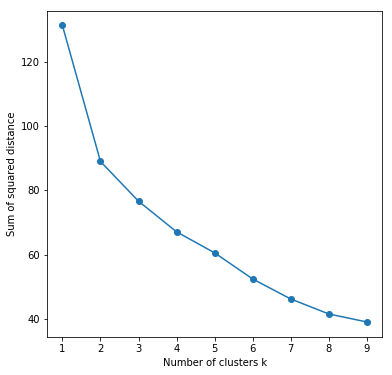

In [55]:
sse = [] # errors
list_k = list(range(1, 10)) 
flag = None

for k in list_k:
    km = KMeans(init = "k-means++",n_clusters=k)
    km.fit(porto_clustering_weighted)
    sse.append(km.inertia_)  # error of k-means
    if (sse[k-1]<sse[0]/np.e) and (flag==None):
        print('max error: ',sse[0])
        print('(max error)/e : ',sse[0]/np.e)
        print('k=',k,': error=',sse[k-1])
        flag = 1

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared distance');

We will use k=7

__Find the best number of independent initializations of centroids__  

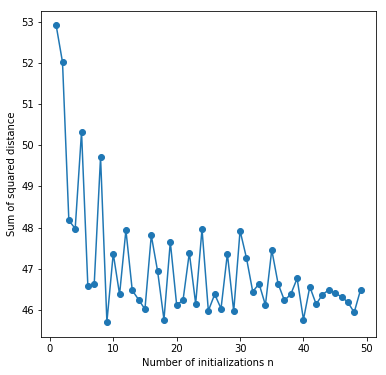

In [56]:
sse = []
list_n_init = list(range(1, 50))

for n in list_n_init:
    km = KMeans(init = "k-means++",n_clusters=7, n_init=n)
    km.fit(porto_clustering_weighted)
    sse.append(km.inertia_)

# Plot sse against n
plt.figure(figsize=(6, 6))
plt.plot(list_n_init, sse, '-o')
plt.xlabel(r'Number of initializations n')
plt.ylabel('Sum of squared distance');

We will use n=30  
In this way we're trying to reduce fluctuations in clustering results

__LOAD CLUSTERING LABELS FROM BACKUP__

In [57]:
# Put the code below into comments
# if you run the script for the 1st time
# and haven't got backed up clustering data

labels_df = pd.read_csv('labels.csv')

labels = labels_df['Cluster'].values
print(labels)

labels_df.head(0)

[3 3 0 3 3 0 5 3 1 3 3 5 3 5 1 0 3 2 3 1 2 4 2 2 6 6 6 1 2 4 4 3 1 0 0 1 0
 0 1 0 3 4 4 0 1]


,Parish,Cluster


In [58]:
# Uncomment this code if haven't carried out clustering yet
'''
k = 7 # number of clusters for k-means
n = 30 # number of initializations 

clusters = KMeans(init = "k-means++",n_clusters=k, n_init=n)

clusters.fit(porto_clustering_weighted)
labels = clusters.labels_ 
labels
''';

In [59]:
porto_labeled_df = pd.DataFrame(porto_clustering_weighted[porto_clustering_weighted.columns])
porto_labeled_df['Cluster'] = 'NA'

# Move cluster column to the front of the table
fixed_columns = [porto_labeled_df.columns[-1]] + list(porto_labeled_df.columns[:-1])
porto_labeled_df = porto_labeled_df[fixed_columns]

# Merge data based on Parish
porto_labeled_df = porto_city_df[['Municipality','Parish','Latitude','Longitude']].join(porto_labeled_df, on=['Parish'])

porto_labeled_df['Cluster'] = labels 
porto_labeled_df.head()

,Municipality,Parish,Latitude,Longitude,Cluster,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
0,Gondomar,Baguim do Monte (Rio Tinto),41.187473,-8.537759,3,0.391304,1.728814,0.091549,0.000000,0.0,0.000000,0.0,0.000000,0.133333,0.4,0.000000,1.0,0.060606,0.0
1,Gondomar,Fânzeres,41.171488,-8.531211,3,0.456522,1.601695,0.098592,0.000000,0.0,0.090909,0.0,0.000000,0.000000,0.0,0.571429,0.0,0.060606,0.4
2,Gondomar,São Pedro da Cova,41.153457,-8.506091,0,0.086957,0.940678,0.000000,0.000000,0.2,0.090909,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,Gondomar,Gondomar (São Cosme),41.135273,-8.534104,3,0.565217,1.194915,0.204225,0.083333,0.0,0.363636,0.0,0.285714,0.133333,0.4,0.285714,0.0,0.060606,0.0
4,Gondomar,Valbom,41.137576,-8.562042,3,1.065217,1.627119,0.352113,0.041667,0.0,0.090909,0.0,0.285714,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [60]:
# create map
cluster_map = folium.Map(location=[porto_centre[0], porto_centre[1]], zoom_start=11,width='70%',height='80%')

x = np.arange(k) # k is the number of clusters
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)-2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(porto_labeled_df['Latitude'], porto_labeled_df['Longitude'], porto_labeled_df['Parish'], porto_labeled_df['Cluster']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) +')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(cluster_map)
    
folium.Marker(feup,popup=folium.Popup('Porto University, FEUP', parse_html=True)).add_to(cluster_map)
folium.Marker(porto_centre,popup=folium.Popup('Porto City Centre', parse_html=True)).add_to(cluster_map)
#folium.Marker(airport,popup=folium.Popup('Porto Airport', parse_html=True)).add_to(cluster_map)

cluster_map

__Backup cluster labels:__

In [61]:
# Uncomment this code if haven't backed up clustering data yet
'''
labels = porto_labeled_df.loc[:,['Parish','Cluster']]
labels.to_csv('labels.csv',index=False)
''';

# 4. ANALYSIS
__First, let's get centroids profiles in terms of weighted feature indices__

## 4.1. Adding clustering centroids to Data

__LOAD CENTROIDS FROM BACKUP:__

In [62]:
# Put the code below into comments
# if you run the script for the 1st time
# and haven't got backed up clustering data

centroids = pd.read_csv('centroids.csv')
centroids

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
0,0.386473,0.629944,0.567293,0.004630,0.088889,0.111111,0.000000,0.190476,0.029630,0.222222,0.031746,0.111111,0.020202,0.044444
1,0.774457,1.242585,0.804577,0.078125,0.125000,0.840909,0.125000,0.678571,0.158333,0.900000,0.357143,0.125000,0.306818,0.050000
2,1.560870,2.094915,0.630986,0.225000,0.480000,1.381818,0.000000,1.314286,0.613333,1.440000,0.285714,0.000000,0.739394,1.600000
3,0.637681,1.783898,0.342723,0.031250,0.033333,0.325758,0.000000,0.166667,0.105556,0.300000,0.214286,0.166667,0.073232,0.133333
4,1.373913,2.049153,0.615493,0.091667,0.360000,0.654545,0.000000,0.685714,0.386667,1.440000,0.342857,1.200000,0.309091,0.640000
5,0.536232,1.754237,0.535211,0.013889,0.066667,0.090909,0.333333,0.380952,0.044444,0.400000,0.285714,2.000000,0.030303,0.133333
6,1.891304,2.033898,0.629108,0.847222,0.200000,1.303030,0.000000,0.000000,0.600000,0.533333,0.857143,0.666667,0.868687,0.933333


In [63]:
# Uncomment this code if haven't backed up clustering data yet
'''
centroids = pd.DataFrame(clusters.cluster_centers_,columns=porto_clustering_weighted.columns)
centroids
''';

__Let's back up data with clustering centroids__

In [64]:
# Uncomment this code if haven't backed up clustering data yet
'''
centroids.to_csv('centroids.csv',index=False)
''';

To get feature ranks for centroids we include them into porto_labeled_df dataframe  
as new Parishes with coordinates of City Centre

In [65]:
centroids_porto_labeled = pd.DataFrame(columns=porto_labeled_df.columns)

for index in centroids.index:
    row = pd.DataFrame([['','Cluster {}'.format(index),porto_centre[0],porto_centre[1],index]+list(centroids.iloc[index,:])],
                      columns=porto_labeled_df.columns)
    centroids_porto_labeled = centroids_porto_labeled.append(row)

porto_labeled_with_centroids = porto_labeled_df.append(centroids_porto_labeled).reset_index(drop=True)
porto_labeled_with_centroids.tail(8)

,Municipality,Parish,Latitude,Longitude,Cluster,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
44,Matosinhos,Matosinhos,41.182060,-8.681925,1,0.456522,1.169492,0.908451,0.041667,0.200000,1.727273,1.000000,0.571429,0.466667,0.400000,0.000000,1.000000,0.636364,0.000000
45,,Cluster 0,41.149451,-8.610788,0,0.386473,0.629944,0.567293,0.004630,0.088889,0.111111,0.000000,0.190476,0.029630,0.222222,0.031746,0.111111,0.020202,0.044444
46,,Cluster 1,41.149451,-8.610788,1,0.774457,1.242585,0.804577,0.078125,0.125000,0.840909,0.125000,0.678571,0.158333,0.900000,0.357143,0.125000,0.306818,0.050000
47,,Cluster 2,41.149451,-8.610788,2,1.560870,2.094915,0.630986,0.225000,0.480000,1.381818,0.000000,1.314286,0.613333,1.440000,0.285714,0.000000,0.739394,1.600000
48,,Cluster 3,41.149451,-8.610788,3,0.637681,1.783898,0.342723,0.031250,0.033333,0.325758,0.000000,0.166667,0.105556,0.300000,0.214286,0.166667,0.073232,0.133333
49,,Cluster 4,41.149451,-8.610788,4,1.373913,2.049153,0.615493,0.091667,0.360000,0.654545,0.000000,0.685714,0.386667,1.440000,0.342857,1.200000,0.309091,0.640000
50,,Cluster 5,41.149451,-8.610788,5,0.536232,1.754237,0.535211,0.013889,0.066667,0.090909,0.333333,0.380952,0.044444,0.400000,0.285714,2.000000,0.030303,0.133333
51,,Cluster 6,41.149451,-8.610788,6,1.891304,2.033898,0.629108,0.847222,0.200000,1.303030,0.000000,0.000000,0.600000,0.533333,0.857143,0.666667,0.868687,0.933333


## 4.2. Development of informative Parish profile  

__Let's create a typical profile for each Parish to make easier analysis of clusters__  
_We cannot simply find 5 most frequent venues in each Parish!  
This will not be informative, because there are Parishes with very low venue index._  

In [66]:
def get_top_features(row, num_top_features):
    '''This function sorts the feature in descending order 
    and returns the list of top-n features:'''
    row_categories = row.iloc[:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_sorted = row_categories_sorted[row_categories_sorted > 0]
      
    return row_categories_sorted.index.values[0:num_top_features] 

Instead, we define a function, returning top-5 features of a Parish 
together with its place among other Parishes:

In [67]:
def get_ranks(parish, features, base):
    '''base = dataframe with feature indices of all Parishes'''

    '''This function returns a list of actual rank categories
    among all Parishes for given Parish and the list of its features
    '''
    ranks = []
    
    # We divide Parishes into 3 bins
    bins = np.linspace(0,len(base),4) 
    names = ['Top','Normal','Outsider']
    
    for feature in features:
        base_sorted = base.sort_values(by=feature,ascending=False)
        base_sorted.reset_index(inplace=True, drop = True)      
        ranks.append(base_sorted[base_sorted['Parish']==parish].index[0]+1)
    
    # Create rank categories
    ranks =  pd.cut(ranks,bins=bins,labels=names,include_lowest=True)
    return ranks

__Now we can find ranks of top-5 features for all Parishes including cluster centroids__

In [68]:
n_top_features = 5

indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = list(porto_labeled_with_centroids.columns[:5])
#columns.append('Top {} venues'.format(n_top_venues))
for ind in np.arange(n_top_features):
    try:
        columns.append('{}{} Feature'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Feature'.format(ind+1))

# create a new dataframe
overview_df = pd.DataFrame(porto_labeled_with_centroids[columns[:-n_top_features]],columns = columns)

# Populate this dataframe row by row with 
for i in np.arange(overview_df.shape[0]):
    top_features = get_top_features(porto_labeled_with_centroids.iloc[i,5:], n_top_features)
    ranks = get_ranks(parish=porto_labeled_with_centroids.iloc[i,1],features=top_features,base=porto_labeled_with_centroids)
    
    overview_df.iloc[i, 5:5+len(top_features)] = top_features,ranks

overview_df.fillna(value='',inplace=True)

for col in range(5,len(overview_df.columns)):
    for index in range(len(overview_df)):
        try:
            overview_df.iloc[index,col] = '{} | {}'.format(overview_df.iloc[index,col][0],overview_df.iloc[index,col][1])
        except:
            pass
    
overview_df.head()

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
0,Gondomar,Baguim do Monte (Rio Tinto),41.187473,-8.537759,3,Unversity_FEUP_km | Normal,Public Transport | Top,Food Stores & Markets | Normal,Remoteness_km | Outsider,Food Places | Normal
1,Gondomar,Fânzeres,41.171488,-8.531211,3,Unversity_FEUP_km | Normal,Nature | Top,Remoteness_km | Outsider,Shopping | Normal,To_sea_km | Outsider
2,Gondomar,São Pedro da Cova,41.153457,-8.506091,0,Unversity_FEUP_km | Outsider,Basic Shops & Services | Normal,Café and Desserts | Outsider,Remoteness_km | Outsider,
3,Gondomar,Gondomar (São Cosme),41.135273,-8.534104,3,Unversity_FEUP_km | Outsider,Remoteness_km | Normal,Food Stores & Markets | Normal,Café and Desserts | Normal,Nature | Normal
4,Gondomar,Valbom,41.137576,-8.562042,3,Unversity_FEUP_km | Normal,Remoteness_km | Normal,To_sea_km | Outsider,Fitness & Sports | Normal,Café and Desserts | Outsider


In [69]:
#Export this to Excel for better view
#Column Top-5 can be wrapped in Excel cells
'''
with pd.ExcelWriter('overview.xlsx',engine='xlsxwriter') as writer:
    overview_df.to_excel(writer, sheet_name='Sheet1',index=False,encoding='utf8')
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    wrap_format = workbook.add_format({'text_wrap': True,'align': 'Top'})
    worksheet.set_column('A:I', 15, wrap_format)
    worksheet.set_column('J:J', 25, wrap_format)
    writer.save()
''';

## 4.3 Exploration of clusters

__We also can find full ranked feature profile for each centroid__

In [70]:
centroids_ranked = pd.DataFrame(columns=['Cluster'] + list(centroids.columns))

for index in centroids.index:
    
    ranks = []
    ranks = list(get_ranks('Cluster {}'.format(index),centroids.columns,porto_labeled_with_centroids))
    ranks.insert(0,'Cluster {}'.format(index))
    row = pd.DataFrame([ranks], columns=centroids_ranked.columns)
    centroids_ranked = centroids_ranked.append(row)

centroids_ranked = centroids_ranked.set_index('Cluster')
centroids_ranked

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 0,Outsider,Outsider,Normal,Normal,Normal,Outsider,Normal,Outsider,Outsider,Outsider,Normal,Normal,Outsider,Normal
Cluster 1,Normal,Outsider,Top,Normal,Normal,Top,Top,Top,Normal,Top,Top,Normal,Top,Normal
Cluster 2,Top,Top,Normal,Top,Top,Top,Normal,Top,Top,Top,Normal,Normal,Top,Top
Cluster 3,Normal,Normal,Outsider,Normal,Normal,Normal,Normal,Outsider,Normal,Outsider,Normal,Normal,Normal,Normal
Cluster 4,Top,Top,Normal,Top,Top,Normal,Normal,Top,Top,Top,Top,Top,Top,Top
Cluster 5,Normal,Normal,Normal,Normal,Normal,Outsider,Top,Normal,Outsider,Normal,Normal,Top,Outsider,Normal
Cluster 6,Top,Top,Normal,Top,Normal,Top,Outsider,Outsider,Top,Normal,Top,Top,Top,Top


## 4.4. Description of clusters one by one

## 1) Cluster "0" (violet)
__View Parishes in that cluster__  

In [71]:
overview_df[overview_df['Cluster']==0]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
2,Gondomar,São Pedro da Cova,41.153457,-8.506091,0,Unversity_FEUP_km | Outsider,Basic Shops & Services | Normal,Café and Desserts | Outsider,Remoteness_km | Outsider,
5,Gondomar,Jovim,41.112590,-8.522397,0,Unversity_FEUP_km | Outsider,Fitness & Sports | Normal,To_sea_km | Outsider,Remoteness_km | Outsider,Restaurants | Outsider
15,Matosinhos,Santa Cruz do Bispo,41.217050,-8.675059,0,Unversity_FEUP_km | Outsider,To_sea_km | Top,Food Stores & Markets | Outsider,Fitness & Sports | Normal,Basic Shops & Services | Normal
33,Vila Nova de Gaia,Avintes,41.105401,-8.550708,0,Food Stores & Markets | Normal,Unversity_FEUP_km | Outsider,Remoteness_km | Outsider,Shopping | Top,To_sea_km | Outsider
34,Vila Nova de Gaia,Canelas,41.080543,-8.600659,0,To_sea_km | Top,Remoteness_km | Outsider,Nature | Normal,Unversity_FEUP_km | Outsider,Café and Desserts | Outsider
36,Vila Nova de Gaia,Gulpilhares,41.076222,-8.636538,0,To_sea_km | Top,Fitness & Sports | Outsider,Basic Shops & Services | Top,Remoteness_km | Outsider,Food Places | Normal
37,Vila Nova de Gaia,Madalena,41.106331,-8.642952,0,Public Transport | Top,To_sea_km | Top,Remoteness_km | Normal,Unversity_FEUP_km | Outsider,Food Stores & Markets | Normal
39,Vila Nova de Gaia,Vilar do Paraíso,41.098407,-8.611931,0,Remoteness_km | Normal,To_sea_km | Top,Unversity_FEUP_km | Outsider,Fitness & Sports | Normal,Café and Desserts | Outsider
43,Vila Nova de Gaia,Vilar de Andorinho,41.101582,-8.576659,0,Unversity_FEUP_km | Outsider,Remoteness_km | Normal,To_sea_km | Normal,Food Stores & Markets | Normal,Café and Desserts | Outsider
45,,Cluster 0,41.149451,-8.610788,0,Unversity_FEUP_km | Outsider,To_sea_km | Normal,Remoteness_km | Outsider,Food Stores & Markets | Outsider,Fitness & Sports | Outsider


__View full profile of the centroid:__  

In [72]:
centroids_ranked[centroids_ranked.index == 'Cluster 0']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 0,Outsider,Outsider,Normal,Normal,Normal,Outsider,Normal,Outsider,Outsider,Outsider,Normal,Normal,Outsider,Normal


__View top-5 features of the centroid:__  

In [73]:
overview_df[overview_df['Parish']=='Cluster 0']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
45,,Cluster 0,41.149451,-8.610788,0,Unversity_FEUP_km | Outsider,To_sea_km | Normal,Remoteness_km | Outsider,Food Stores & Markets | Outsider,Fitness & Sports | Outsider


### __OBSERVATIONS__:  
This cluster (__violet, Cluster 0__) is the __worst__ in the majority of features,  
though in average it has several normal-level traits: _distance to the sea, nature, and some basic shops and services._  
  
__No top features__ in cluster.
### __Cluster name:__ "Outsiders"

## 2) Cluster "1" (blue)
__View Parishes in that cluster__  

In [74]:
overview_df[overview_df['Cluster']==1]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
8,Maia,Cidade da Maia,41.227261,-8.616982,1,Unversity_FEUP_km | Normal,Fitness & Sports | Top,Café and Desserts | Top,Food Stores & Markets | Normal,Nature | Top
14,Matosinhos,Leça da Palmeira,41.194023,-8.696498,1,Food Stores & Markets | Top,To_sea_km | Top,Unversity_FEUP_km | Outsider,Café and Desserts | Normal,Restaurants | Top
19,Porto,Foz do Douro,41.151305,-8.670185,1,Unversity_FEUP_km | Outsider,Café and Desserts | Top,To_sea_km | Top,Remoteness_km | Normal,Food Stores & Markets | Normal
27,Porto,Lordelo do Ouro,41.154044,-8.651083,1,Nature | Top,Unversity_FEUP_km | Normal,Remoteness_km | Top,Food Stores & Markets | Top,To_sea_km | Top
32,Vila do Conde,Canidelo,41.127088,-8.651075,1,Food Stores & Markets | Top,Unversity_FEUP_km | Outsider,Remoteness_km | Normal,To_sea_km | Top,Fitness & Sports | Top
35,Vila Nova de Gaia,Canidelo,41.127088,-8.651075,1,Food Stores & Markets | Top,Unversity_FEUP_km | Outsider,Remoteness_km | Normal,To_sea_km | Top,Fitness & Sports | Normal
38,Vila Nova de Gaia,Mafamude,41.115211,-8.604945,1,Unversity_FEUP_km | Outsider,Remoteness_km | Normal,Fitness & Sports | Top,Café and Desserts | Top,To_sea_km | Normal
44,Matosinhos,Matosinhos,41.182060,-8.681925,1,Café and Desserts | Top,Unversity_FEUP_km | Outsider,Public Transport | Top,Car Service | Top,To_sea_km | Top
46,,Cluster 1,41.149451,-8.610788,1,Unversity_FEUP_km | Outsider,Food Stores & Markets | Top,Café and Desserts | Top,To_sea_km | Top,Remoteness_km | Normal


__View full profile of the centroid:__  

In [75]:
centroids_ranked[centroids_ranked.index == 'Cluster 1']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 1,Normal,Outsider,Top,Normal,Normal,Top,Top,Top,Normal,Top,Top,Normal,Top,Normal


__View top-5 features of the centroid:__  

In [76]:
overview_df[overview_df['Parish']=='Cluster 1']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
46,,Cluster 1,41.149451,-8.610788,1,Unversity_FEUP_km | Outsider,Food Stores & Markets | Top,Café and Desserts | Top,To_sea_km | Top,Remoteness_km | Normal


### __OBSERVATIONS__:  
This cluster (__blue, Cluster 1__) has a lot of advantages, but is quite __remote from the University__.  
  
Normal-level traits: _Remoteness, Alcohol venues, Basic shops & Services, Shopping, Transport, Food places._  
High-level traits: _Restaurants, Nature, Fitness & Sports, Car Service_
  
__Main top features (on average):__ _Food Stores & Markets, Café and Desserts, Distance to the sea._  
### __Cluster name:__ "Good but far"

  
## 3) Cluster "2" (light blue)
__View Parishes in that cluster__  

In [77]:
overview_df[overview_df['Cluster']==2]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
17,Matosinhos,Senhora da Hora,41.186311,-8.650549,2,Unversity_FEUP_km | Normal,Shopping | Top,Food Stores & Markets | Top,Fitness & Sports | Top,Café and Desserts | Top
20,Porto,Bonfim,41.152711,-8.597608,2,Unversity_FEUP_km | Top,Food Stores & Markets | Top,Café and Desserts | Top,Remoteness_km | Top,Shopping | Top
22,Porto,Cedofeita,41.158350,-8.621314,2,Unversity_FEUP_km | Top,Fitness & Sports | Top,Café and Desserts | Top,Remoteness_km | Top,Food Stores & Markets | Top
23,Porto,Santo Ildefonso,41.153628,-8.607705,2,Unversity_FEUP_km | Top,Shopping | Top,Remoteness_km | Top,Food Stores & Markets | Top,Café and Desserts | Top
28,Porto,Massarelos,41.149678,-8.631936,2,Unversity_FEUP_km | Top,Remoteness_km | Top,Shopping | Top,Fitness & Sports | Top,Nature | Top
47,,Cluster 2,41.149451,-8.610788,2,Unversity_FEUP_km | Top,Shopping | Top,Remoteness_km | Top,Food Stores & Markets | Top,Café and Desserts | Top


__View full profile of the centroid:__  

In [78]:
centroids_ranked[centroids_ranked.index == 'Cluster 2']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 2,Top,Top,Normal,Top,Top,Top,Normal,Top,Top,Top,Normal,Normal,Top,Top


__View top-5 features of the centroid:__  

In [79]:
overview_df[overview_df['Parish']=='Cluster 2']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
47,,Cluster 2,41.149451,-8.610788,2,Unversity_FEUP_km | Top,Shopping | Top,Remoteness_km | Top,Food Stores & Markets | Top,Café and Desserts | Top


### __OBSERVATIONS__:  
This cluster (__light blue, Cluster 2__) might be one of the best. It isn't far from the University and it is in the top-list
in many venues.

__On average:__
Normal-level traits: _Distance to the sea, Car Service, Nature, Public Transport._  
High-level traits: _Alcohol venues, Restaurants, Food Places, Fitness & Sports, Basic shops & Services_
  
__Main top features:__ _Good (but not the best) proximity to the University, Shopping venues, City Centre, Food Stores & Markets, Café and Desserts_  
### __Cluster name:__ "Optimum | City Centre"

  
## 4) Cluster "3" (green)
__View Parishes in that cluster__  

In [80]:
overview_df[overview_df['Cluster']==3]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
0,Gondomar,Baguim do Monte (Rio Tinto),41.187473,-8.537759,3,Unversity_FEUP_km | Normal,Public Transport | Top,Food Stores & Markets | Normal,Remoteness_km | Outsider,Food Places | Normal
1,Gondomar,Fânzeres,41.171488,-8.531211,3,Unversity_FEUP_km | Normal,Nature | Top,Remoteness_km | Outsider,Shopping | Normal,To_sea_km | Outsider
3,Gondomar,Gondomar (São Cosme),41.135273,-8.534104,3,Unversity_FEUP_km | Outsider,Remoteness_km | Normal,Food Stores & Markets | Normal,Café and Desserts | Normal,Nature | Normal
4,Gondomar,Valbom,41.137576,-8.562042,3,Unversity_FEUP_km | Normal,Remoteness_km | Normal,To_sea_km | Outsider,Fitness & Sports | Normal,Café and Desserts | Outsider
7,Maia,Águas Santas,41.207759,-8.572750,3,Unversity_FEUP_km | Top,Nature | Top,Café and Desserts | Normal,Remoteness_km | Outsider,Fitness & Sports | Normal
9,Maia,Milheirós,41.219309,-8.586569,3,Unversity_FEUP_km | Normal,Nature | Normal,To_sea_km | Outsider,Remoteness_km | Outsider,Café and Desserts | Outsider
10,Maia,Pedrouços,41.187801,-8.587277,3,Unversity_FEUP_km | Top,Remoteness_km | Normal,Café and Desserts | Normal,Food Stores & Markets | Outsider,To_sea_km | Outsider
12,Matosinhos,Leça do Balio,41.212037,-8.627969,3,Unversity_FEUP_km | Normal,Food Stores & Markets | Normal,To_sea_km | Normal,Remoteness_km | Outsider,Shopping | Top
16,Matosinhos,São Mamede de Infesta,41.193432,-8.609791,3,Unversity_FEUP_km | Top,Remoteness_km | Normal,Café and Desserts | Normal,To_sea_km | Outsider,Food Stores & Markets | Normal
18,Porto,Aldoar,41.167935,-8.668306,3,Unversity_FEUP_km | Normal,To_sea_km | Top,Remoteness_km | Normal,Shopping | Top,Café and Desserts | Normal


__View full profile of the centroid:__  

In [81]:
centroids_ranked[centroids_ranked.index == 'Cluster 3']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 3,Normal,Normal,Outsider,Normal,Normal,Normal,Normal,Outsider,Normal,Outsider,Normal,Normal,Normal,Normal


__View top-5 features of the centroid:__  

In [82]:
overview_df[overview_df['Parish']=='Cluster 3']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
48,,Cluster 3,41.149451,-8.610788,3,Unversity_FEUP_km | Normal,Remoteness_km | Normal,To_sea_km | Outsider,Café and Desserts | Normal,Food Stores & Markets | Outsider


### __OBSERVATIONS__:  
This cluster (__green, Cluster 3__) is the Mediocrity. And outsider in  
in _Distance to the sea (except Aldoar), Fitness & Sports venues and in Food Stores & Markets._

_Distance to the University_ is different and is normal on average. But there are both Parishes  
very close to FEUP and distant.
  
__Main top features:__ _No top-level features_
### __Cluster name:__ "Mediocrity"

  
## 5) Cluster "4" (yellow)
__View Parishes in that cluster__  

In [83]:
overview_df[overview_df['Cluster']==4]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
21,Porto,Campanhã,41.159674,-8.576985,4,Unversity_FEUP_km | Top,Shopping | Top,Fitness & Sports | Top,Remoteness_km | Top,Food Stores & Markets | Top
29,Porto,Paranhos,41.173513,-8.605900,4,Unversity_FEUP_km | Top,Food Stores & Markets | Top,Remoteness_km | Top,Café and Desserts | Top,Public Transport | Top
30,Porto,Ramalde,41.171649,-8.642028,4,Unversity_FEUP_km | Top,Food Stores & Markets | Top,Remoteness_km | Top,Public Transport | Top,Fitness & Sports | Top
41,Vila Nova de Gaia,Santa Marinha,41.130485,-8.620331,4,Unversity_FEUP_km | Normal,Remoteness_km | Top,Food Stores & Markets | Top,Public Transport | Top,To_sea_km | Normal
42,Vila Nova de Gaia,São Pedro da Afurada,41.142999,-8.641865,4,Public Transport | Top,Unversity_FEUP_km | Normal,Food Stores & Markets | Top,Remoteness_km | Top,Shopping | Top
49,,Cluster 4,41.149451,-8.610788,4,Unversity_FEUP_km | Top,Food Stores & Markets | Top,Remoteness_km | Top,Public Transport | Top,Fitness & Sports | Top


__View full profile of the centroid:__  

In [84]:
centroids_ranked[centroids_ranked.index == 'Cluster 4']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 4,Top,Top,Normal,Top,Top,Normal,Normal,Top,Top,Top,Top,Top,Top,Top


__View top-5 features of the centroid:__  

In [85]:
overview_df[overview_df['Parish']=='Cluster 4']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
49,,Cluster 4,41.149451,-8.610788,4,Unversity_FEUP_km | Top,Food Stores & Markets | Top,Remoteness_km | Top,Public Transport | Top,Fitness & Sports | Top


### __OBSERVATIONS__:  
This cluster (__yellow, Cluster 4__) looks like one of the best.  
It is spread along the perimeter of City Centre.  
It isn't far from the University and it is in the top-list in the most venues.

__On average:__
Normal-level traits: _Distance to the sea, Car Service, Café and Desserts._  
High-level traits: _all the others._  
The closest Parish to the University is Paranhos, the most remote is Santa Marinha. 
  
__Main top features:__ _Good proximities to the University and to the City Centre,  
Food Stores & Markets, Fitness & Sports venues, Public Transport infrastructure_
### __Cluster name:__ "Optimum | Daily Life"

  
## 6) Cluster "5" (orange)
__View Parishes in that cluster__  

In [86]:
overview_df[overview_df['Cluster']==5]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
6,Gondomar,Rio Tinto,41.180717,-8.557569,5,Unversity_FEUP_km | Top,Public Transport | Top,Nature | Top,Fitness & Sports | Top,Food Stores & Markets | Normal
11,Matosinhos,Custóias,41.206756,-8.645745,5,Public Transport | Top,Unversity_FEUP_km | Normal,Car Service | Top,To_sea_km | Normal,Remoteness_km | Outsider
13,Matosinhos,Guifões,41.205435,-8.661509,5,Public Transport | Top,Unversity_FEUP_km | Normal,To_sea_km | Top,Remoteness_km | Outsider,Fitness & Sports | Normal
50,,Cluster 5,41.149451,-8.610788,5,Public Transport | Top,Unversity_FEUP_km | Normal,Remoteness_km | Normal,To_sea_km | Normal,Food Stores & Markets | Normal


__View full profile of the centroid:__  

In [87]:
centroids_ranked[centroids_ranked.index == 'Cluster 5']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 5,Normal,Normal,Normal,Normal,Normal,Outsider,Top,Normal,Outsider,Normal,Normal,Top,Outsider,Normal


__View top-5 features of the centroid:__  

In [88]:
overview_df[overview_df['Parish']=='Cluster 5']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
50,,Cluster 5,41.149451,-8.610788,5,Public Transport | Top,Unversity_FEUP_km | Normal,Remoteness_km | Normal,To_sea_km | Normal,Food Stores & Markets | Normal


### __OBSERVATIONS__:  
This cluster (__orange, Cluster 5__) is normal almost in all parameters.   

It's __main peculiarity__ is that its Parishes are good in Public Transport.  
However, this is mostly because of their location not far from railway stations.  

Also, they are not very far from the University and well-connected with it by rail lines.  

__Drawbacks:__ The cluster is outsider in food places such as _fast food, restaurants and cafés_  
High-level traits: _Car Service, Public Transport._  
  
__Main top features:__ _Public Transport_  
### __Cluster name:__ "Rail stations only"

  
## 7) Cluster "6" (red)
__View Parishes in that cluster__  

In [89]:
overview_df[overview_df['Cluster']==6]

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
24,Porto,Sé,41.149451,-8.610788,6,Unversity_FEUP_km | Top,Remoteness_km | Top,Café and Desserts | Top,Food Stores & Markets | Top,Public Transport | Top
25,Porto,Miragaia,41.145485,-8.620929,6,Nature | Top,Unversity_FEUP_km | Top,Remoteness_km | Top,Café and Desserts | Top,Restaurants | Top
26,Porto,Vitória,41.146769,-8.614988,6,Unversity_FEUP_km | Top,Remoteness_km | Top,Café and Desserts | Top,Shopping | Top,Public Transport | Top
51,,Cluster 6,41.149451,-8.610788,6,Unversity_FEUP_km | Top,Remoteness_km | Top,Café and Desserts | Top,Shopping | Top,Restaurants | Top


__View full profile of the centroid:__  

In [90]:
centroids_ranked[centroids_ranked.index == 'Cluster 6']

,Remoteness_km,Unversity_FEUP_km,To_sea_km,Alcohol,Basic Shops & Services,Café and Desserts,Car Service,Fitness & Sports,Food Places,Food Stores & Markets,Nature,Public Transport,Restaurants,Shopping
Cluster,,,,,,,,,,,,,,
Cluster 6,Top,Top,Normal,Top,Normal,Top,Outsider,Outsider,Top,Normal,Top,Top,Top,Top


__View top-5 features of the centroid:__  

In [91]:
overview_df[overview_df['Parish']=='Cluster 6']

,Municipality,Parish,Latitude,Longitude,Cluster,1st Feature,2nd Feature,3rd Feature,4th Feature,5th Feature
51,,Cluster 6,41.149451,-8.610788,6,Unversity_FEUP_km | Top,Remoteness_km | Top,Café and Desserts | Top,Shopping | Top,Restaurants | Top


### __OBSERVATIONS__:  
This cluster (__red, Cluster "6"__) is the __Central Core__. It's main features are all in the top.   
There is a __lack in__ _Car Service and Fitness & Sports venues_  
 

__On Average:__  Normal-level traits: _Food Stores & Markets, Basic Shops & Services, Distance to the sea_    
High-level traits: _Alcohol Venues, Food Places, Nature (due to city gardens), Public Transport._  
  
__Main features in the top-list:__ _Good proximity to University, the very City Center, Café and Desserts, Shopping venues, Restaurants_  
### __Cluster name:__ "Central Core"

## 4.5. Update the Map
Now we can add Cluster Names

In [92]:
porto_named_df = pd.DataFrame(porto_labeled_df[['Municipality','Parish','Latitude','Longitude','Cluster']])
porto_named_df['Cluster Name'] = 'NA'

cluster_names = np.array(['Outsiders','Good but far','Optimum | City Centre','Mediocrity','Optimum | Daily Life','Rail stations only','Central Core'])
porto_named_df['Cluster Name'] = cluster_names[porto_named_df['Cluster']]

porto_named_df.head()

,Municipality,Parish,Latitude,Longitude,Cluster,Cluster Name
0,Gondomar,Baguim do Monte (Rio Tinto),41.187473,-8.537759,3,Mediocrity
1,Gondomar,Fânzeres,41.171488,-8.531211,3,Mediocrity
2,Gondomar,São Pedro da Cova,41.153457,-8.506091,0,Outsiders
3,Gondomar,Gondomar (São Cosme),41.135273,-8.534104,3,Mediocrity
4,Gondomar,Valbom,41.137576,-8.562042,3,Mediocrity


In [93]:
# create map
cluster_map = folium.Map(location=[porto_centre[0], porto_centre[1]], zoom_start=11,width='70%',height='80%')

x = np.arange(k) # k is the number of clusters
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)-2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, name in zip(porto_named_df['Latitude'],
                                        porto_named_df['Longitude'],
                                        porto_named_df['Parish'],
                                        porto_named_df['Cluster'],
                                        porto_named_df['Cluster Name']):
    label = folium.Popup(str(poi) + ' (Cluster: "' + str(name) +'")', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(cluster_map)
    
folium.Marker(feup,popup=folium.Popup('Porto University, FEUP', parse_html=True)).add_to(cluster_map)
folium.Marker(porto_centre,popup=folium.Popup('Porto City Centre', parse_html=True)).add_to(cluster_map)
#folium.Marker(airport,popup=folium.Popup('Porto Airport', parse_html=True)).add_to(cluster_map)

cluster_map

# THE END